# Model: Light BGM 

In [1]:
from comet_ml import Experiment

In [2]:
import pandas as pd
import numpy as np
import requests
import json
import os
import math
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

In [3]:
import pickle

import sys
sys.path.append('../ift6758/visualizations/')

from question_5_plots import *

In [4]:
experiment = Experiment(
    api_key=os.environ.get('COMET_API_KEY'),
    project_name="LightGBM-q6",
    workspace="kleitoun"
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/kleitoun/lightgbm-q6/47161d262d404bf180b156c4ab66800a



In [27]:
experiment.url
Experiment(log_code=True)

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/kleitoun/lightgbm-q6/47161d262d404bf180b156c4ab66800a
COMET INFO:   Metrics:
COMET INFO:     accuracy : 0.7658772251258413
COMET INFO:     f1_score : 0.2705723298783236
COMET INFO:   Parameters:
COMET INFO:     boosting_type                : gbdt
COMET INFO:     clip                         : False
COMET INFO:     colsample_bytree             : 1.0
COMET INFO:     copy                         : True
COMET INFO:     cv                           : 1
COMET INFO:     early_stopping_round         : 1
COMET INFO:     error_score                  : nan
COMET INFO:     estimator                    : LGBMClassifier(is_unbalance=True, metric='auc', num_boost_round=2000,
               objective='binary')
COMET INFO:     estimator__boosting_type     : gbdt
C

In [5]:
# Load dataframe from Q4
data = "final_df.csv"
df = pd.read_csv(data)
df = df[df['season'] != 20192020]
df_game = df[['game_id']]

In [6]:
old_feat = ['game_id', 'season', 'season_type', 'event_id', 'home_team',
       'away_team', 'home_team_side_1st_period', 'attacking_team',
       'attacking_player', 'goalie', 'period', 'period_time', 'goal_ind',
       'shot_ind', 'x_coordinates', 'y_coordinates', 'shot_type', 'empty_net',
       'strength', 'gwg', 'previous_event_x_coordinates',
       'previous_event_y_coordinates', 'previous_event_period_time',
       'previous_event_type', 'previous_event_period', 'previous_attacking_team',
       'attacking_team_side']

df_feat = df.iloc[:,:60].columns.tolist()

#features extracted in question 4
new_feat = [feat for feat in df_feat if feat not in old_feat]
print(len(old_feat),len(df_feat),len(new_feat) )
X = df[new_feat]
y = df['goal_ind']
X.columns

27 60 33


Index(['home_players', 'away_players', 'distance_from_net', 'angle_from_net',
       'game_seconds', 'previous_event_game_seconds', 'time_since_last_event',
       'distance_from_last_event', 'rebound', 'rebound_same_team',
       'home_team_attacking', 'overtime', 'speed', '5v5', '4v4', '3v3', '5v4',
       '5v3', '4v3', '4v5', '3v5', '3v4', 'power_play', 'penalty_kill',
       'change_in_angle', 'shot_type_Backhand', 'shot_type_Deflected',
       'shot_type_Slap Shot', 'shot_type_Snap Shot', 'shot_type_Tip-In',
       'shot_type_Wrap-around', 'shot_type_Wrist Shot', 'goalie_Aaron Dell'],
      dtype='object')

# Independent variable normalization (MinMax Normalization)


In [7]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)
df_ind = pd.DataFrame(X_minmax,columns = X.columns) # Normalized dataframe which has the same size as the master dataframe

In [8]:
df_ind.columns

Index(['home_players', 'away_players', 'distance_from_net', 'angle_from_net',
       'game_seconds', 'previous_event_game_seconds', 'time_since_last_event',
       'distance_from_last_event', 'rebound', 'rebound_same_team',
       'home_team_attacking', 'overtime', 'speed', '5v5', '4v4', '3v3', '5v4',
       '5v3', '4v3', '4v5', '3v5', '3v4', 'power_play', 'penalty_kill',
       'change_in_angle', 'shot_type_Backhand', 'shot_type_Deflected',
       'shot_type_Slap Shot', 'shot_type_Snap Shot', 'shot_type_Tip-In',
       'shot_type_Wrap-around', 'shot_type_Wrist Shot', 'goalie_Aaron Dell'],
      dtype='object')

# PCA for dimensionality reduction


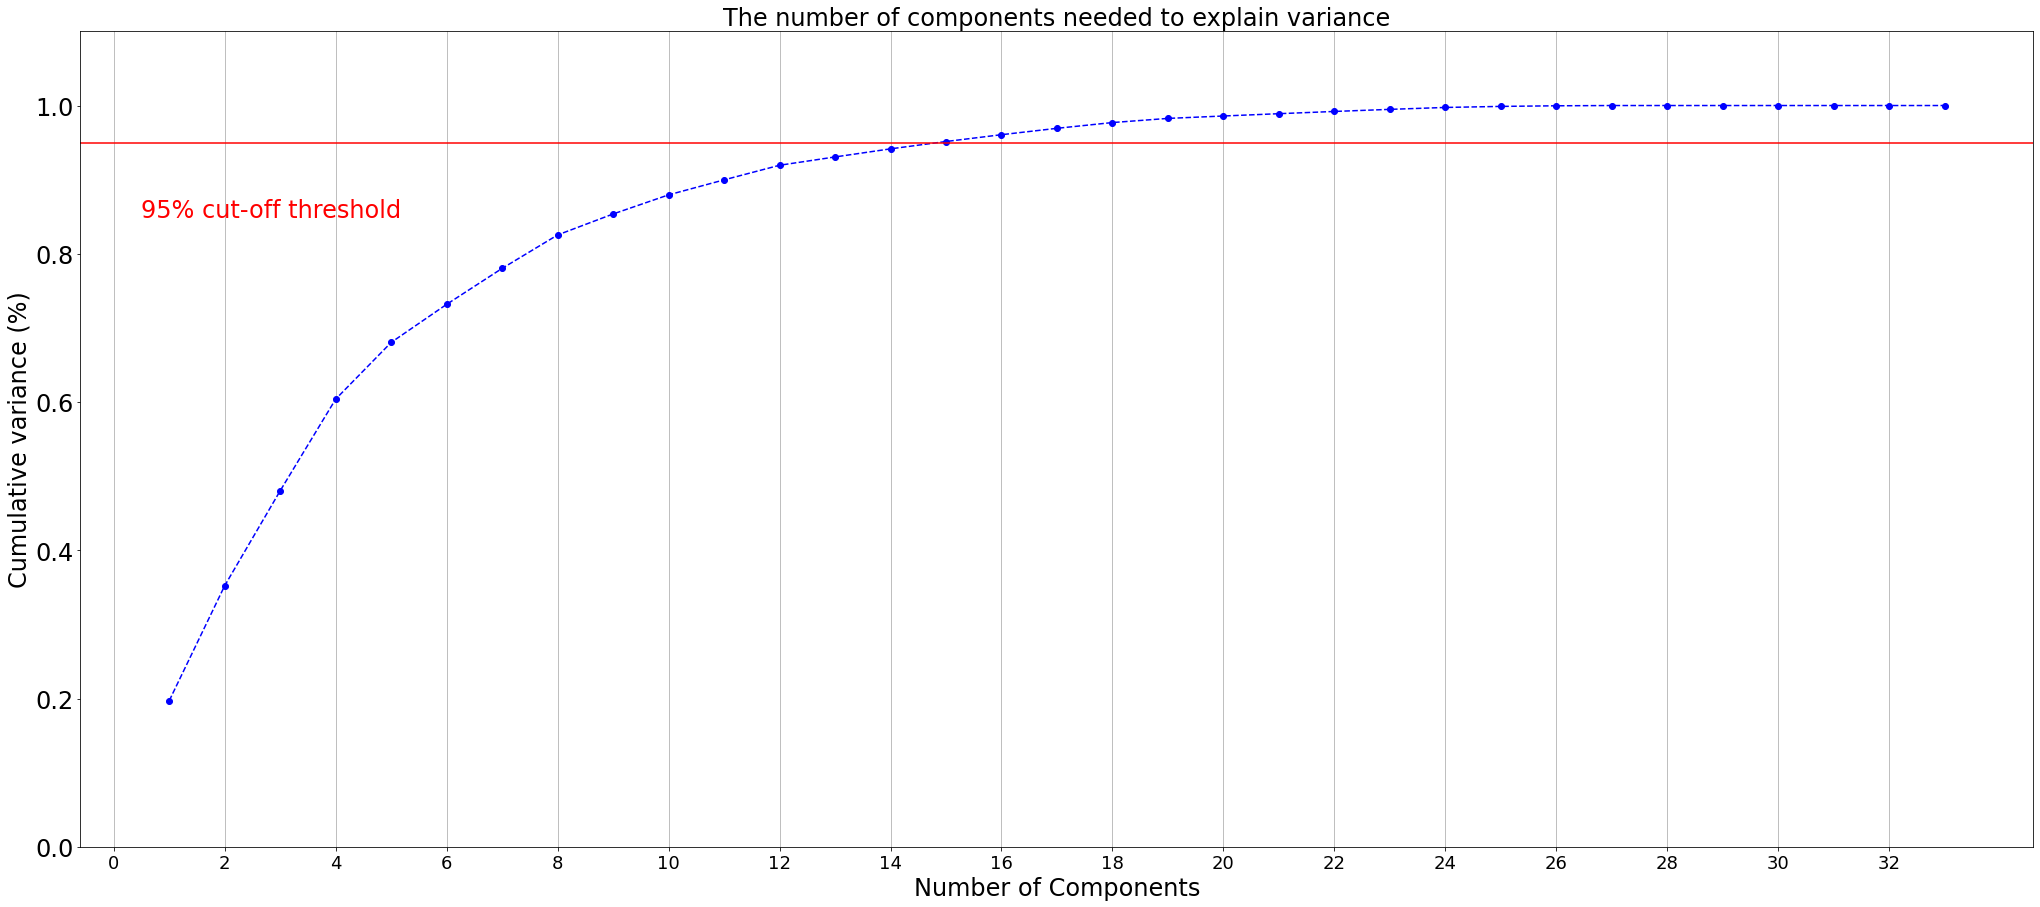

In [9]:
pca = PCA().fit(df_ind)
plt.rcParams["figure.figsize"] = (35,15)
fig, ax = plt.subplots()
xi = np.arange(1, df_ind.shape[1]+1, step=1)
yi = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components',size = 24)
plt.xticks(np.arange(0, df_ind.shape[1]+1, step=2))
plt.ylabel('Cumulative variance (%)',size = 24)
plt.title('The number of components needed to explain variance',size = 24)

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=24)
plt.yticks(size = 24)
plt.xticks(size = 18)
ax.grid(axis='x')
plt.show()

In [10]:
pca.feature_names_in_

array(['home_players', 'away_players', 'distance_from_net',
       'angle_from_net', 'game_seconds', 'previous_event_game_seconds',
       'time_since_last_event', 'distance_from_last_event', 'rebound',
       'rebound_same_team', 'home_team_attacking', 'overtime', 'speed',
       '5v5', '4v4', '3v3', '5v4', '5v3', '4v3', '4v5', '3v5', '3v4',
       'power_play', 'penalty_kill', 'change_in_angle',
       'shot_type_Backhand', 'shot_type_Deflected', 'shot_type_Slap Shot',
       'shot_type_Snap Shot', 'shot_type_Tip-In', 'shot_type_Wrap-around',
       'shot_type_Wrist Shot', 'goalie_Aaron Dell'], dtype=object)

# Training set transformation to significant PCA

In [11]:
pca = PCA(n_components=16,svd_solver='full')
X_pca_red = pca.fit_transform(df_ind)
print(df_ind.shape,X_pca_red.shape,y.shape)

(311106, 33) (311106, 16) (311106,)


In [12]:
pca_col_list=[]
for i in range(X_pca_red.shape[1]):
    pca_col_list.append(f'PCA{i}')
df_pca_red = pd.DataFrame(X_pca_red,columns=pca_col_list)
df_pca_red = pd.concat([df_pca_red,df_game,y],axis=1)

In [13]:
df_pca_red.columns

Index(['PCA0', 'PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8',
       'PCA9', 'PCA10', 'PCA11', 'PCA12', 'PCA13', 'PCA14', 'PCA15', 'game_id',
       'goal_ind'],
      dtype='object')

# Test Train Split - Every 3rd game taken into validation set

In [14]:
df_group_Train = df_pca_red[df_pca_red['game_id'] % 3 != 0]
df_group_Test = df_pca_red[df_pca_red['game_id'] % 3 == 0]
print(df_group_Train.shape, df_group_Test.shape)

(207404, 18) (103702, 18)


In [15]:
X_train = df_group_Train.drop(['goal_ind','game_id'],axis=1)
X_valid = df_group_Test.drop(['goal_ind','game_id'],axis=1)
y_train = df_group_Train['goal_ind']
y_valid = df_group_Test['goal_ind']

print(X_train.shape, X_valid.shape,y_train.shape, y_valid.shape)

(207404, 16) (103702, 16) (207404,) (103702,)


# Hyperparameter Tuning using GridSearchCV

In [16]:
search_param = {'max_depth': [2,50],
                'num_leaves': [5, 100],
                'feature_fraction': [0.4,1]}

lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary', num_boost_round=2000, metric='auc',is_unbalance=True)

scoring = {'AUC': 'roc_auc'}
gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=search_param, scoring=scoring, refit='AUC')
lgb_model = gsearch.fit(X=X_train, y=y_train)

print(lgb_model.best_params_, lgb_model.best_score_)

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
{'feature_fraction': 0.4, 'max_depth': 2, 'num_leaves': 5} 0.7392299387974897


# LGBMClassifier

Training using Light GBM algorithm ....
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


C:\Users\chait\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
COMET ERROR: Error creating confusion matrix: 0; ignoring


Accuracy score: 0.7658772251258413
confusion matrix:
 [[74920 19079]
 [ 5200  4503]]
recall is  0.630556514425084
precision is  0.5630240395491912
fscore is  0.5948797921238925


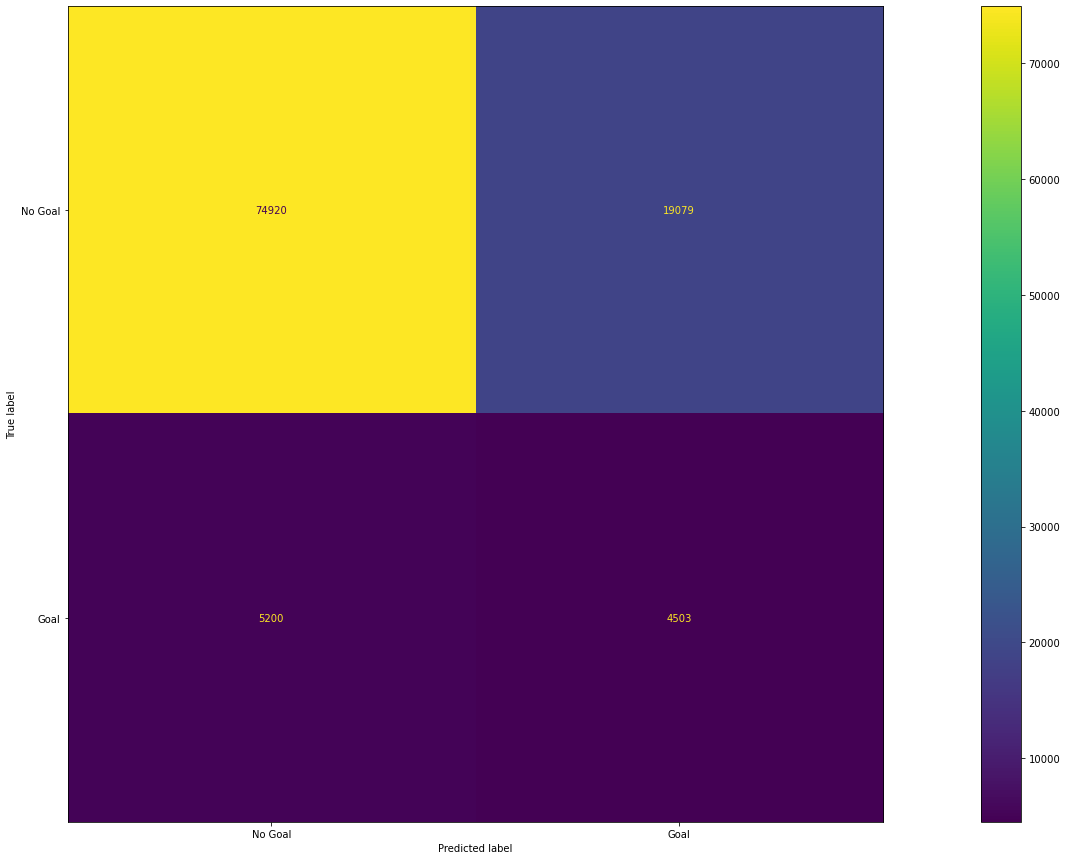

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,f1_score
import matplotlib.pyplot as plt

optim_param = {'max_depth': [2],
                'num_leaves': [5],
                'feature_fraction': [0.4]}

print("Training using Light GBM algorithm ....")
rf = LGBMClassifier(learning_rate=0.1,boosting_type='gbdt',  objective='binary', num_boost_round=2000, metric='auc',is_unbalance=True)

rf.fit(X_train, y_train)
rfc_predict = rf.predict(X_valid)
pickle.dump(rf,open('LightGBM','wb'))
# Metrics calculation
print('Accuracy score:',accuracy_score(y_valid, rfc_predict))
cm = confusion_matrix(y_valid, rfc_predict,labels = [0,1])
print('confusion matrix:\n',cm)
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
print("recall is ",np.mean(recall))
print("precision is ", np.mean(precision))
fscore = (2*np.mean(recall)*np.mean(precision))/(np.mean(recall) + np.mean(precision))
print("fscore is ",fscore)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["No Goal","Goal"])
disp.plot()
experiment.log_metric("accuracy", accuracy_score(y_valid, rfc_predict))
experiment.log_metric("f1_score", f1_score(y_valid, rfc_predict))
experiment.log_confusion_matrix(y_valid, rfc_predict)

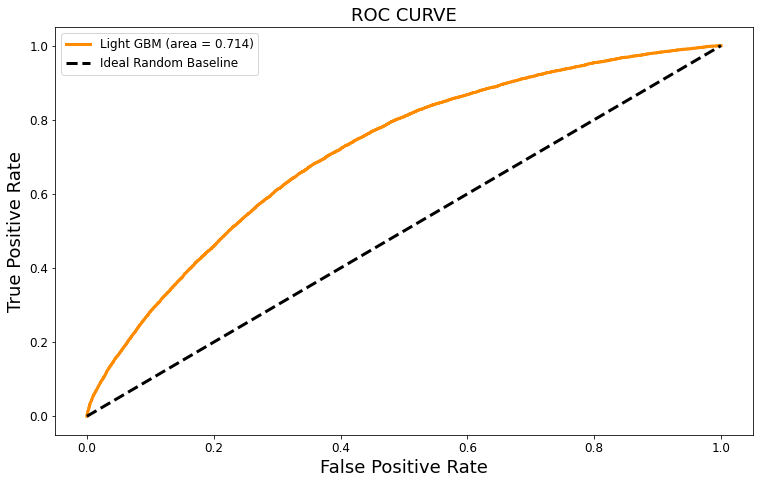

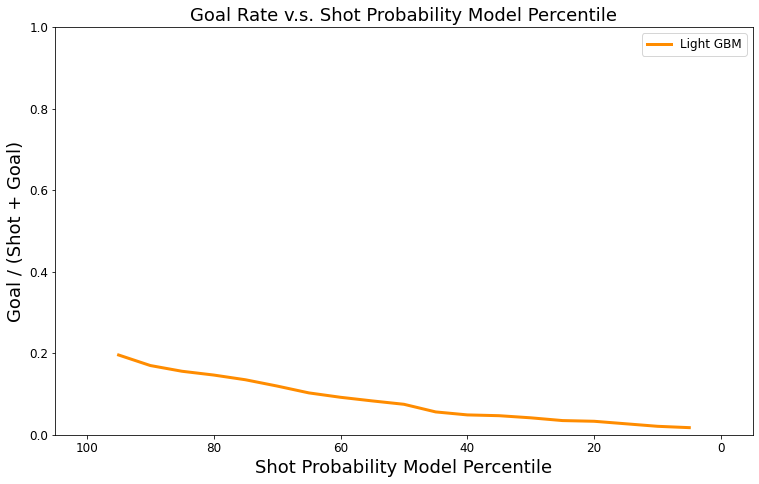

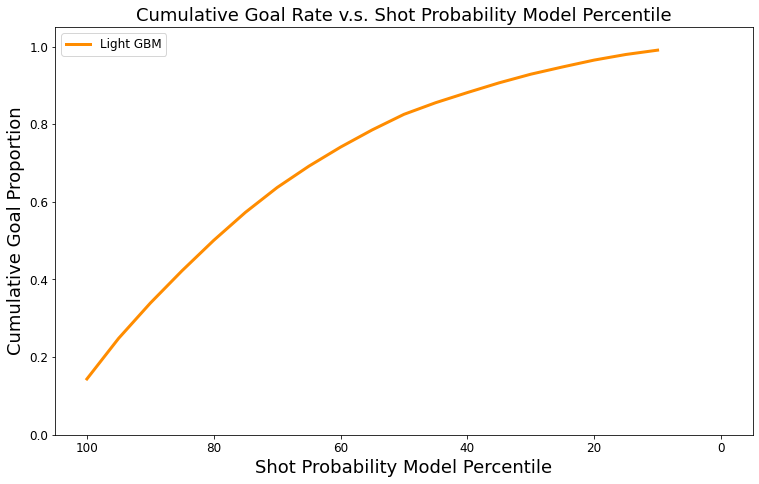

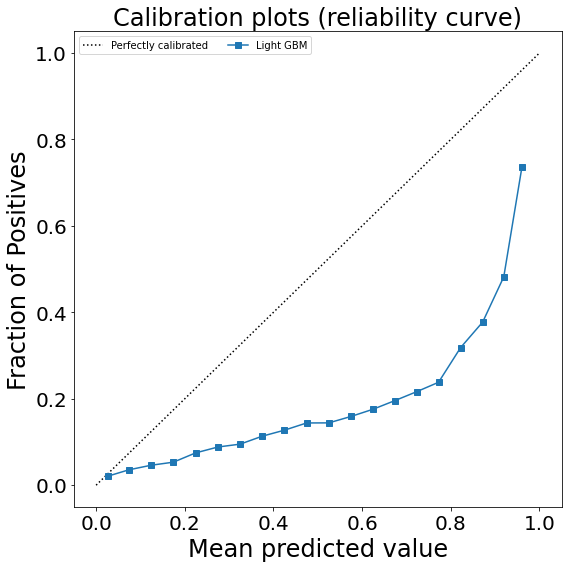

In [18]:
question_no = 6
# perf_eval = Performance_Eval(model, X_train, y_train, X_valid, y_valid, question_no = question_no)
perf_eval = Performance_Eval(rf,'Light GBM',X_train, y_train, X_valid, y_valid, question_no = question_no)
perf_eval.get_roc_auc_plot()
perf_eval.get_goal_rate_plot()
perf_eval.get_cum_rate_plot()
perf_eval.get_calibration_plot()

# Plots to inquest our model's performance

Plot1: Receiver Operating Characteristic (ROC) curves and the AUC metric of the ROC curve.

Plot2:The goal rate (#goals / (#no_goals + #goals)) as a function of the shot probability model percentile

Plot3: The cumulative proportion of goals (not shots) as a function of the shot probability model percentile.

Plot4: The reliability diagram (calibration curve).

In [20]:
experiment.log_image(image_data="../../ift6758-blog-template-main/figures/milestone2/Q6Light GBM_ROC_Curve.png", overwrite=False)
experiment.log_image(image_data="../../ift6758-blog-template-main/figures/milestone2/Q6Light GBM_Goal_Rate.png", overwrite=False)
experiment.log_image(image_data="../../ift6758-blog-template-main/figures/milestone2/Q6Light GBM_Cum_Goal.png", overwrite=False)
experiment.log_image(image_data="../../ift6758-blog-template-main/figures/milestone2/Q6Light GBM_Calibration_Curve.png", overwrite=False)

{'web': 'https://www.comet.ml/api/image/download?imageId=c9e6d33d2ddf4730a81d07f52f26e5d5&experimentKey=47161d262d404bf180b156c4ab66800a',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=c9e6d33d2ddf4730a81d07f52f26e5d5&experimentKey=47161d262d404bf180b156c4ab66800a',
 'imageId': 'c9e6d33d2ddf4730a81d07f52f26e5d5'}

In [21]:
Experiment.end

<function comet_ml.experiment.BaseExperiment.end(self)>